[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mcity/mcity_data_engine/blob/main/fish_eye_8k_colab.ipynb)


# 1. Introduction
To get a first feel of the Mcity Data Engine, we provide an online demo in a Google Colab environment. We will load the Fisheye8K dataset and demonstrate the Mcity Data Engine workflow Embedding Selection. This workflow leverage a set of models to compute image embeddings. This subset will finally be visualized in the Voxel51 UI, highlighting how often a sample was picked by a model.

## After opening in Google Colab, you can Run All (as per the below image) for the outcome or follow the steps below:

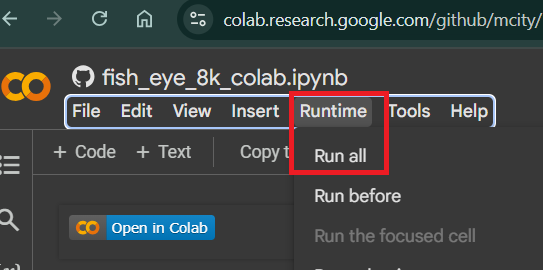



# 2. Step-by-Step Instructions

## Step 1: Clone Git repo

In [ ]:
!git clone https://github.com/mcity/mcity_data_engine.git

## Step 2: Copy code to execution path

In [ ]:
!cp -R mcity_data_engine/* .

## Step 3: Modify config for Colab workflow:

In [ ]:
!pip install typed-ast

In [ ]:
import ast
import _ast


config_file_path = './config/config.py'

UPDATED_WORKFLOWS =    { "embedding_selection": {
        "mode": "compute",
        "parameters": {
            "compute_representativeness": 0.99,
            "compute_unique_images_greedy": 0.01,
            "compute_unique_images_deterministic": 0.99,
            "compute_similar_images": 0.03,
            "neighbour_count": 3,
        },
        "embedding_models": [
            "detection-transformer-torch",
            "zero-shot-detection-transformer-torch",
            "clip-vit-base32-torch",
        ],
    },}

class ConfigVisitor(ast.NodeTransformer):
        def visit_Assign(self, node):
            # Look for the assignment of the variables we want to modify
            if isinstance(node.targets[0], _ast.Name):
                if node.targets[0].id == "SELECTED_WORKFLOW":
                    node.value = ast.Constant(value=["embedding_selection"] )
                elif node.targets[0].id == "WORKFLOWS":
                    node.value = ast.Constant(value=UPDATED_WORKFLOWS)
                elif node.targets[0].id == "WANDB_ACTIVE":
                    node.value = ast.Constant(value=False)
                elif node.targets[0].id == "V51_REMOTE":
                    node.value = ast.Constant(value=False)                                      
            return node

    # Transform the AST
transformer = ConfigVisitor()

with open(config_file_path, "r") as file:
    content = file.read()

parsed_ast = ast.parse(content)
updated_ast = transformer.visit(parsed_ast)

    # Convert AST back to source code
    
updated_content = ast.unparse(updated_ast)

with open(config_file_path, "w") as file:
    file.write(updated_content)

print("Config file updated successfully.")



## Step 4: Install Colab specific data engine requirements

In [ ]:
%%capture
!pip install -r requirements_colab.txt

## Step 5: Configure Huggingface timeout variables

In [ ]:
!export HF_HUB_ETAG_TIMEOUT=5000
!export HF_HUB_DOWNLOAD_TIMEOUT=1000

## Step 6: Download sample dataset

In [ ]:
from fiftyone.utils.huggingface import load_from_hub

dataset = load_from_hub(
    "Voxel51/fisheye8k",
    name = "fisheye8k",
    max_samples=1000,
)

## Step 7: start embeddings workflow

In [ ]:
!python main.py

## Step 8: Set up the Voxel51 app layout for the dataset for which embeddings are computed

In [ ]:
import fiftyone as fo
samples_panel = fo.Panel(type="Samples", pinned=True)

embeddings_panel = fo.Panel(
    type="Embeddings",
    state=dict(brainResult="clip_vit_base32_torch_umap", colorByField="embedding_selection_count"),
)

spaces = fo.Space(
    children=[
                fo.Space(children=[samples_panel]),
                fo.Space(children=[embeddings_panel]),
            ],
    orientation="horizontal",
)
fo.launch_app(dataset=fo.load_dataset('fisheye8k'),spaces=spaces)

# 3. Handling Errors and Troubleshooting
* If Colab requests a session restart after installing requirements, ignore the error and proceed.
* The Voxel51 app may take 1-2 minutes to launch, depending on your internet speed.
* If no images appear in the Samples Panel or Embeddings Panel, manually click on the Samples or Embeddings tab to load them (refer Voxel51 [Tutorial](https://docs.voxel51.com/tutorials/image_embeddings.html)).

# 4. Additional Notes and Best Practices
* Always ensure your runtime is set to GPU for optimal performance.
* Keep an eye on execution logs for warnings or errors.
* Save your work frequently to avoid losing progress.


By following this manual, you will be able to execute the Fish Eye 8K notebook in Google Colab efficiently. Happy coding!